#### CSCI-UA.0473-​001 Introduction to Machine Learning

# Homework 3


### Name: Christina Liu


### Due: Oct. 30, 2019


## Goal:  The goal of this homework is to practice implementing kernels for support vector machine and to find regularization parameter via cross validation.

Please DO NOT change the position of any cell in this assignment. If the notebook is stunned sometimes before the cell that defines SVM class, please restart it.

You will need the following packages below to do the homework.  Please DO NOT import any other packages.

## WARNING!
Some parts below (especially part 3 with cross-validation) could take a while to run ~30 min.  If it takes much longer than this then you likely have an error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Loading and spliting data (already finished)
For this assignment, we utilized the iris dataset from sklearn library. Most of the setting is the same as HW2, except the training/test are split in $70\%/30\%$.
* `X_train`, `y_train` are `features`, `labels` for training, while `X_test`, `y_test` are for test.

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 0, :2]
y = y[y != 0]
y[y==2] = -1

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.7 * n_sample)]
y_train = y[:int(.7 * n_sample)]
X_test = X[int(.7 * n_sample):]
y_test = y[int(.7 * n_sample):]

## 1. Implement kernels
Recall that, in HW2, we only used inner product as the kernel, i.e. $K(x,z)=x^{\mathsf{T}}z$. This time we are going implement four kernels:
* linear: $K(x,z)=x^{\mathsf{T}}z+c$
* gaussian: $K(x,z)=\exp\left(-\frac{\left\lVert x-z \right\rVert^2}{2\sigma^2}\right)$
* polynomial: $K(x,z)=\left(x^{\mathsf{T}}z+c\right)^d$
* lacplacian: $K(x,z)=\exp\left(-\frac{\left\lVert x-z \right\rVert}{2\sigma^2}\right)$

Let's set $c=1, d=2, \sigma=1$. Please implement these four kernels within the follow `inner_product` function.

There are a list of kernel functions at http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/

In [24]:
def inner_product(vector_0, vector_1, kernel='linear'):
    """
    Compute the inner product of two vectors.
    
    intput:
        vector_0: np.ndarray(dim0,)
        vector_1: np.ndarray(dim0,)
        kernel: str, name of kernel
    
    output:
        value of kernel functions K(vector_0, vector_1)
    """
    c = 1.0;
    d = 2.0;
    sigma = 1.0;
    
    kernel = kernel.lower()
    
    if kernel not in ['linear', 'gaussian', 'polynomial', 'laplacian']:
        print('Undefined kernel!')
        exit()

    assert vector_0.shape == vector_1.shape
    
    if kernel == 'linear':
        #TODO
        return np.inner(vector_0,vector_1) + c
    elif kernel == 'gaussian':
        #TODO
        return np.exp(-(np.linalg.norm(vector_0-vector_1)**2)/(2*sigma**2)) 
    elif kernel == 'polynomial':
        #TODO
        return (np.inner(vector_0,vector_1) + c)**d
    elif kernel == 'laplacian':
        #TODO
        return np.exp(-(np.linalg.norm(vector_0-vector_1))/(2*sigma**2))  

In [25]:
def inner_product_matrix(train_data, kernel='linear'):
    """
    Compute the inner product matrix of two vectors.
    
    input:
        train_data: np.ndarray(nb_data, dim), nb_data data points in dimension of 'dim'
    
    output:
        res: np.ndarray(nb_data, nb_data), each entry is the inner product of the corresponding pair of vectors
    """
    res = np.zeros((train_data.shape[0], train_data.shape[0]))
    
    for i in range(train_data.shape[0]):
        for j in range(train_data.shape[0]):
            res[i, j] = inner_product(train_data[i], train_data[j], kernel)
            
    return res

## 2. Implement cross validation
Before that, you need to get familiar with the SVM class defined as follows. An object of SVM class can store training data, training labels and parameters of model. Moreover, it has some useful functions to call.
* _train_data: all training data, in shape of (num_train, dim)
* _train_label: all training labels, in shape of (num_train, )
* _reg: regularization, C in constraints $0\le\alpha_i\le C$ (we had some discussions about C in slides)
* _kernel, the name of kernel you would like to take
* _alpha, all $\alpha_i$, in shape of (num_train, )
* _bias, bias $b$, a scala
* train(): train the SVM model with all parameters, as well as (data, labels) stored in (_train_data, _train_label)
* predict(data): predict the model output of one data point, using the model with current (_train_data, _train_label, _kernel, _alpha, _bias)
* estimate(many_data, labels): estimate the average accuracy over many data points, using the current model.
* **cross_validation**(*num_fold*): validate the setting of regularization parameter via *num_fold*-fold cross validation.

All parts except `cross_validation` have been finished. In `cross_validation`, you need to:
* split the training set into *num_fold* folds with equal size
* build a *num_fold*-loop. In each loop, take one fold as *actual* test set, the others as *actual* training set
* train with actual training set, and estimate on the actual test set
* return the average accuracy of the *num_fold* results.

Please carefully think about how to train the model with the actual training set. Assume we don't care about what is left in the model's variables after finishing the cross validation, because the goal of cross validation is choose an appropriate value of regularization parameter, with which we will train the model on the *whole* training set afterwards.

You will **not immediately** know whether your implementation is correct or not. The next cell is still good to run if you put a `pass` at the TODO in this cell.

In [85]:
class SVM:
    def __init__(self, train_data, train_label, regularization = 10, kernel='linear'):
        assert train_data.shape[0] == train_label.shape[0]
        assert regularization >= 0
    
        self._train_data = train_data
        self._train_label = train_label
        self._reg = regularization
        self._kernel = kernel
        
        self._alpha = np.zeros_like(train_label)
        self._bias = np.zeros([1])
        
        self._target_function = lambda alpha: -1 * (np.sum(alpha) - 0.5 * np.sum(np.diag(self._train_label) @ np.diag(alpha) @ inner_product_matrix(self._train_data, self._kernel) @ np.diag(alpha) @ np.diag(self._train_label)))
        
    def train(self):
        init = np.zeros_like(self._train_label)
        bnds = tuple([(0, self._reg) for i in range(self._train_data.shape[0])])
        cons = ({'type': 'eq', 'fun': lambda x:  x @ self._train_label})
        
        res = minimize(self._target_function, init, method='SLSQP', bounds=bnds,
               constraints=cons)
        
        self._alpha = res.x
        
        self._bias = np.zeros([1])
        bias = 0
        for i in range(self._train_data.shape[0]):
            bias += self._train_label[i] - self.predict(self._train_data[i])

        self._bias = bias / self._train_data.shape[0]
        
    def predict(self, data):
        sum = 0
        for i in range(self._train_data.shape[0]):
            sum += self._alpha[i] * self._train_label[i] * inner_product(self._train_data[i], data, self._kernel)
        
        sum += self._bias
        return sum
    
    def estimate(self, many_data, labels):
        assert many_data.shape[0] == labels.shape[0]
    
        sum = 0
        for i in range(many_data.shape[0]):
            if labels[i] * self.predict(many_data[i]) > 0:
                sum += 1
        return sum / many_data.shape[0]
    
    def cross_validation(self, num_fold=5):
        assert self._train_data.shape[0] % num_fold == 0
        
        all_train_data = self._train_data
        all_train_label = self._train_label
       
        permutation = np.random.permutation(all_train_data.shape[0])
        all_train_data = all_train_data[permutation, :]
        all_train_label = all_train_label[permutation]
        unit = int(all_train_data.shape[0] / num_fold)
        acc_list = []
        print('Cross validation for C=', self._reg, ' :')
        for i in range(num_fold):
            print('Fold ', i, ' / ', num_fold, 'is running!')
            # TODO-start
#             [train1, train2, train3, train4, train5] = np.split(all_train_data,5);
#             train_list = [train1, train2, train3, train4, train5]
#             for ii in train_list:
#                 actual_test_set = ii;
#                 actual_training_set = np.vstack(train_list - ii);
#                 self.train(actual_training_set);
#                 result = self.estimate(actual_test_set);
#                 acc_list.append(result);
            a = unit*i
            b = unit*(i+1)
            self._training_data = all_train_data[a:b]
            self._training_label = all_train_label[a:b]
            self.train();
            
            training_lower_X = all_train_data[:a]
            training_upper_X = all_train_data[b:]
            actual_training_set_X = np.concatenate((training_lower_X, training_upper_X))
            training_lower_y = all_train_label[:a]
            training_upper_y = all_train_label[b:]
            actual_training_set_Y = np.concatenate((training_lower_y, training_upper_y))
            
            result = self.estimate(actual_training_set_X, actual_training_set_Y);
            acc_list.append(result);
            # TODO-end
        return np.mean(acc_list)

## Draw the decision boundaries of all kernels (already finished)
The following is an illustration of decision boundaries for SVM with kernels. 

0.7333333333333333
0.7333333333333333
0.7
0.7


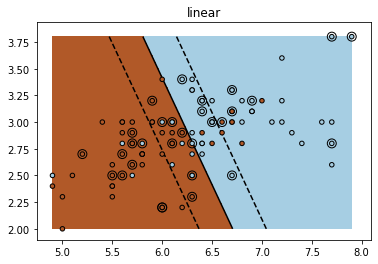

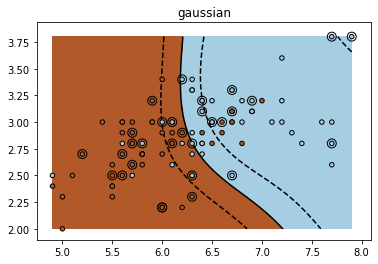

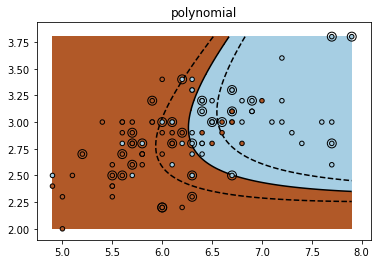

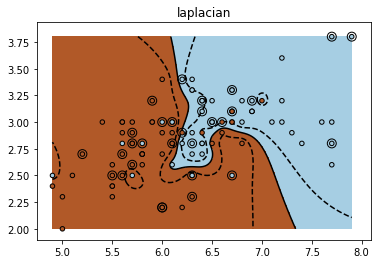

In [34]:
kernel_list = ['linear', 'gaussian', 'polynomial', 'laplacian']

for kernel in kernel_list:
    model = SVM(X_train, y_train, regularization=10, kernel=kernel)
    model.train()

    print(model.estimate(X_test, y_test))

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    XXYY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = []
    for i in range(XXYY.shape[0]):
        ZZ.append(model.predict(XXYY[i]))

    Z = np.array(ZZ)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
    plt.title(kernel)

plt.show()

## 3. Cross validation and pick the best parameter
Here you are going to see whether you previous implementation is correct or not. We provide a $C\_list$ for you to cross validate over. It will output the mean accuracies of all candidates. Pick the one with the best accuracy, and retrain the model with it.

Just use Gaussian kernel and *num_fold*=5. You should get an accuracy ~0.7

In [86]:
C_list = [0, 1, 5, 10, 100, 1000]

for c in C_list:
    # TODO
    model_cv = SVM(X_train, y_train, regularization=c, kernel='gaussian')
    print(model_cv.cross_validation(num_fold=5))

Cross validation for C= 0  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is running!
Fold  3  /  5 is running!
Fold  4  /  5 is running!
0.5142857142857142
Cross validation for C= 1  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is running!
Fold  3  /  5 is running!
Fold  4  /  5 is running!
0.7142857142857143
Cross validation for C= 5  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is running!
Fold  3  /  5 is running!
Fold  4  /  5 is running!
0.7142857142857143
Cross validation for C= 10  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is running!
Fold  3  /  5 is running!
Fold  4  /  5 is running!
0.7285714285714286
Cross validation for C= 100  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is running!
Fold  3  /  5 is running!
Fold  4  /  5 is running!
0.7571428571428571
Cross validation for C= 1000  :
Fold  0  /  5 is running!
Fold  1  /  5 is running!
Fold  2  /  5 is runnin

In [87]:
#TODO
model_final = SVM(X_train, y_train, regularization=5, kernel='gaussian')
model_final.train()
print(model_final.estimate(X_train, y_train))
print(model_final.estimate(X_test, y_test))

0.7142857142857143
0.7333333333333333


## 4. Finding a feature map.

Consider the following dataset shown below, which is just two concentric circles centered at $0$ of radius 1 and 2 corresponding to the two different classes.

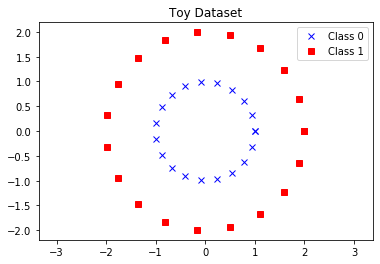

In [88]:
# Plot the toy dataset which is just two circles of radius 1 and 2.

theta = np.linspace(0, 2*np.pi, 20) # Angles.

# Class 0
x0 = np.cos(theta)
y0 = np.sin(theta)

# Class 1
x1 = 2*np.cos(theta)
y1 = 2*np.sin(theta)

# Plot the data.
plt.figure()
plt.plot(x0, y0, 'b x', label = 'Class 0')
plt.plot(x1, y1, 'r s', label = 'Class 1')
plt.axis('equal')
plt.title('Toy Dataset')
plt.legend()
plt.show();

Clearly we should be able to easily separate this data to get a classifier with $100\%$ accuracy since there is no overlap.  

1.  Write down a feature map $\phi : \mathbb{R}^2 \to \mathbb{R}$, such that the transformed data $\phi(x)$ is linearly separable.  

2.  What is the corresponding kernel? 

3.  What is the decision boundary on the original space?

Answer goes here: 
<br /> 1. The feature map is $\sqrt{(x_1)^2+(x_2)^2}$ because it maps from $\phi : \mathbb{R}^2 \to \mathbb{R}$ and it is the formula for a circle.
<br /> 2. The corresponding kernal is $\sqrt{(x_1)^2+(x_2)^2} \cdot \sqrt{(z_1)^2+(z_2)^2}$, which is just the dot product between $\phi(x)^T$ and $\phi(z)$.
<br /> 3. The decision boundary on the original space is $(x)^2 + (y)^2 - (1.5)^2 = 0$ and predict $y=0$ because the boundary between the 2 concentric cirlces is another circle with radius between 1 and 2, which is 1.5.



## 5. Verifying the Polynomial Kernel

Prove that the polynomial kernel $K(u,v) = (u^Tv + 1)^d$ for $d \ge 1$ and $d$ integer is a valid kernel.  This means you need to verify the assumptions of Mercer's theorem that

1. $K$ is symmetric.

2. $K$ is positive semi-definite.

Answer goes here:
<br /> 1. For $K$ to be symmetric, $K(u,v)==K(v,u)$, which means $(u^Tv + 1)^d == (v^Tu + 1)^d$ or $u^Tv == v^Tu$. We know this is true because v and u are feature maps, therefore we proved that $K$ is symmetric.
<br /> 2. In order to be positive semi-definite, the Gram matrix $G \in \mathbf{R}^{nXn}$ must satisfy $u^TGv \geq 0 \forall u \in \mathbf{R}^{n}$. Using functional analysis, one can show that $u^TGv$ corresponds to $<h_u,h_v>$ for some $h_u$ and $h_v$ in some Hilbert Space $\mathbf{H}$. Because $<h_u,h_v> \geq 0$ by the definition of an inner product, then $<h_u,h_v> \geq 0$ and $<h_u,h_v> = u^TGu \geq 0$.
